In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import fbpca

In [4]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [5]:
import graph_learning_utils as gl

# Rewrite algo for faster runs

In [18]:
def objective_with_params_sparse(eta_arr, validation_mat, 
        sample_mats, delta, num_eigs_included=None, verbose=False, use_random_svd=True):
    if num_eigs_included is None:
        num_eigs_included = validation_mat.shape[0]
    P_hat = gl.matrix_lin_combo_pos_sign(eta_arr, sample_mats, sparse=True)

    # singular values, increasing order
    # print('running svd with {} singular values'.format(num_eigs_included))
    if use_random_svd: 
        # print('using random svd with k={}'.format(num_eigs_included))
        # eigvals, _ = fbpca.eigens(validation_mat - P_hat, k = num_eigs_included)
        U, S, Vh = fbpca.pca(validation_mat - P_hat, k = num_eigs_included, n_iter=4)
        diff_sing_values = S
    else: 
        sing_vals = scipy.sparse.linalg.svds(validation_mat - P_hat, solver='arpack',
                                                k=num_eigs_included - 1, return_singular_vectors=False)
        diff_sing_values = np.flip(sing_vals)

    # assumes sing values are in decrasing order
    def ob_fn(k): 
        return sum(diff_sing_values[k:]) - k * delta

    all_obj_values = [ob_fn(k) for k in range(1, num_eigs_included + 1)]
    max_obj_index = np.argmax(all_obj_values)
    # print(all_obj_values, max_obj_index)
    return all_obj_values[max_obj_index]

# Import data

In [7]:
human_ppi_mat = scipy.sparse.load_npz('data/adj_matrix_sparse_restricted_9606.npz')
max_degree =  np.max(human_ppi_mat)
human_ppi_mat /= max_degree

## generate data for run

In [8]:
m = 5 
occlusion_rate = 0.01
occluded_ground_truths = [gl.gen_occluded_p(human_ppi_mat, frac_to_occlude=occlusion_rate) for _ in range(m)]
validation_mat = gl.gen_sparse_sample_boolean_mat(human_ppi_mat)
sample_mats = [gl.gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

## try BFGS with randomized eigvals

In [11]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    'ftol': 1e-12, 
    'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89294D+02    |proj g|=  9.45510D-01
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random sv

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[18.0277161]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 17 instead with accuracy 
4.883691939496698.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[4.88369194]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


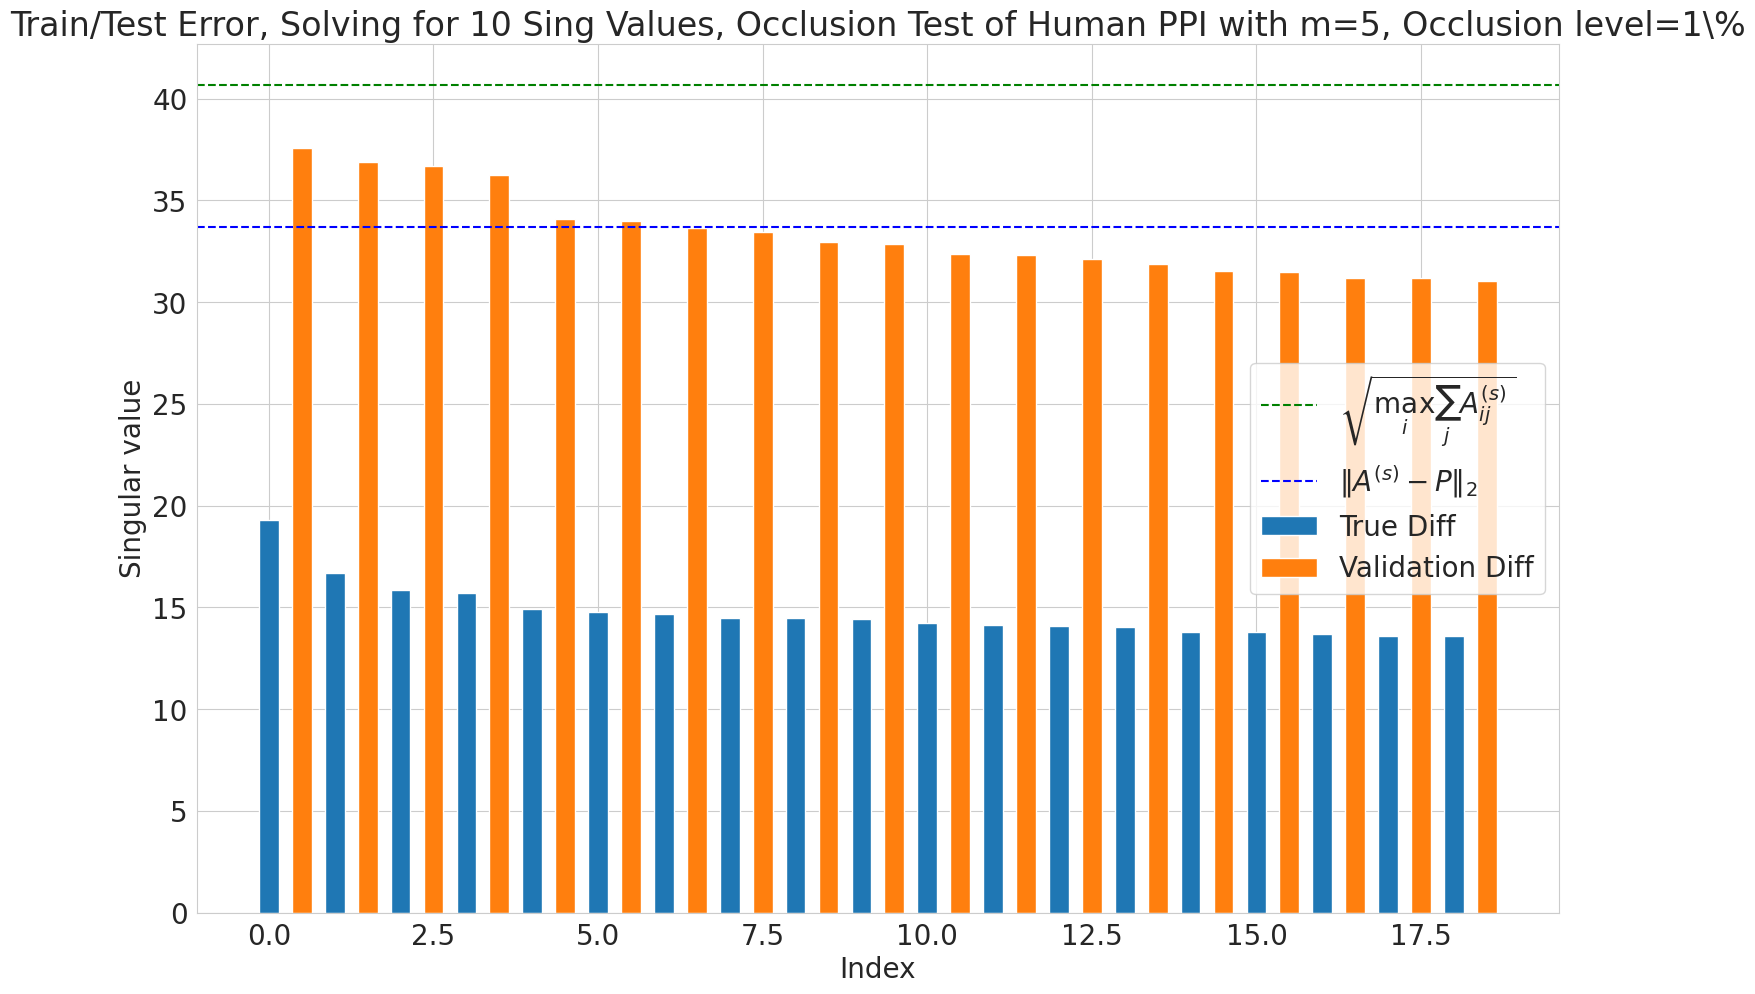

In [13]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, human_ppi_mat, num_eigs_to_include, 20)

Questions: 

* Why is true error always lower than test error? 

* Why is the true delta so high here? Shouldn't it be much lower? 

* Does using a relatively high delta help in convergence? We used around delta=4 here. 

* Can we use an even smaller ftol/gtol?

In [16]:
result_ftol_1e12 = result.copy()

### bfgs with no ftol setting

In [19]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include, use_random_svd=True)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500
    # 'ftol': 1e-12, 
    # 'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09325D+02    |proj g|=  9.76206D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     25      7     0     0   9.762D-01   3.079D+02
  F =   307.93582245342105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.3179239]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.3179239016093875.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.3179239]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


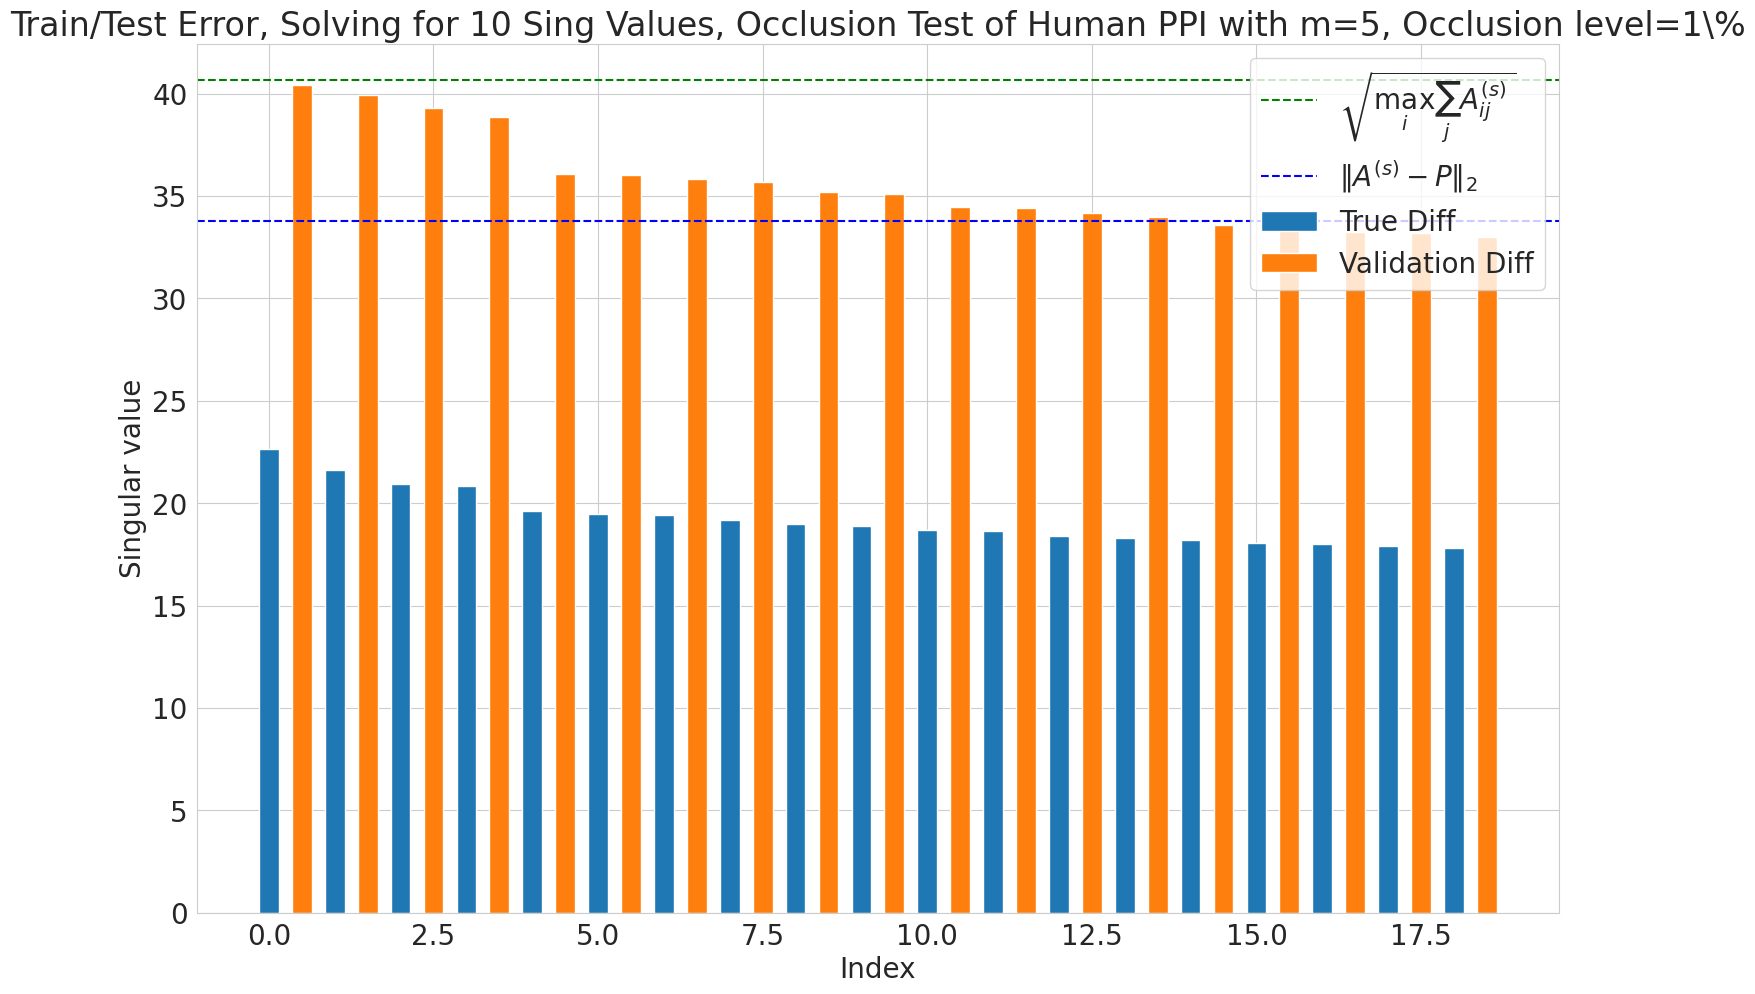

In [20]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, human_ppi_mat, num_eigs_to_include, 20)